## **AdaBoost Forecasting**

In [ ]:
import os
import numpy as np
import copy
from scipy import interpolate
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!git clone https://github.com/KU-DIC/LG_time_series_day06.git

Cloning into 'LG_time_series_day06'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 48 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [ ]:
# import dataset

data = pd.read_csv('/content/LG_time_series_day06/Data_AdaBoost_AirQuality.csv')

del data['Unnamed: 0']
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [ ]:
# select a feature (CO(GT))

name = "CO(GT)"
SIZE = 24

data = data[name]

In [ ]:
# for using t0 ~ t23 (24 times)

COLUMNS = ['t{}'.format(x) for x in range(SIZE)] + ['target']
COLUMNS

['t0',
 't1',
 't2',
 't3',
 't4',
 't5',
 't6',
 't7',
 't8',
 't9',
 't10',
 't11',
 't12',
 't13',
 't14',
 't15',
 't16',
 't17',
 't18',
 't19',
 't20',
 't21',
 't22',
 't23',
 'target']

In [ ]:
time_data = []

for i in range(SIZE, data.shape[0]):
    time_data.append(data.loc[i-SIZE:i].tolist())
time_data = pd.DataFrame(time_data, columns = COLUMNS)
time_data.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,target
0,2.6,2.0,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,1.1,2.0,2.2,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8
1,2.0,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,1.1,2.0,2.2,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9
2,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,1.1,2.0,2.2,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1
3,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,1.1,2.0,2.2,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1,3.9
4,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,1.1,2.0,2.2,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1,3.9,1.5


## Time series components
### base-level, trend, seasonality

In [ ]:
feats_data = pd.DataFrame()
feats_data['prev_1'] = time_data.iloc[:,-2] # Here -2 as -1 is a target

for win in range(3, 27, 3):
    # select columns by recent times
    tmp = time_data.iloc[:,-1-win:-1]
    
    #General statistics for base level
    feats_data['mean_prev_{}'.format(win)] = tmp.mean(axis=1) # mean
    feats_data['median_prev_{}'.format(win)] = tmp.median(axis=1) # median
    feats_data['min_prev_{}'.format(win)] = tmp.min(axis=1) # min
    feats_data['max_prev_{}'.format(win)] = tmp.max(axis=1) # max
    feats_data['std_prev_{}'.format(win)] = tmp.std(axis=1) # standard deviation
    
    #Capturing trend
    feats_data['mean_ewm_prev_{}'.format(win)] = tmp.T.ewm(com=9.5).mean().T.mean(axis=1) # ewm; Exponential Moving Average
    feats_data['last_ewm_prev_{}'.format(win)] = tmp.T.ewm(com=9.5).mean().T.iloc[:,-1]
    
    feats_data['avg_diff_{}'.format(win)] = (tmp - tmp.shift(1, axis=1)).mean(axis=1)
    feats_data['avg_div_{}'.format(win)] = (tmp / tmp.shift(1, axis=1)).mean(axis=1)

In [ ]:
tmp

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23
0,2.6,2.0,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,1.1,2.0,2.2,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9
1,2.0,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,1.1,2.0,2.2,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8
2,2.2,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,1.1,2.0,2.2,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9
3,2.2,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,1.1,2.0,2.2,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1
4,1.6,1.2,1.2,1.0,0.9,0.6,0.7,0.7,0.7,1.1,2.0,2.2,1.7,1.5,1.6,1.9,2.9,2.2,2.2,2.9,4.8,6.9,6.1,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9328,1.4,1.3,1.4,1.0,1.0,1.1,1.3,1.4,1.2,2.7,2.5,1.5,1.6,1.2,0.9,0.6,0.5,0.4,0.5,0.5,1.1,4.0,5.0,3.9
9329,1.3,1.4,1.0,1.0,1.1,1.3,1.4,1.2,2.7,2.5,1.5,1.6,1.2,0.9,0.6,0.5,0.4,0.5,0.5,1.1,4.0,5.0,3.9,3.1
9330,1.4,1.0,1.0,1.1,1.3,1.4,1.2,2.7,2.5,1.5,1.6,1.2,0.9,0.6,0.5,0.4,0.5,0.5,1.1,4.0,5.0,3.9,3.1,2.4
9331,1.0,1.0,1.1,1.3,1.4,1.2,2.7,2.5,1.5,1.6,1.2,0.9,0.6,0.5,0.4,0.5,0.5,1.1,4.0,5.0,3.9,3.1,2.4,2.4


In [ ]:
feats_data

,prev_1,mean_prev_3,median_prev_3,min_prev_3,max_prev_3,std_prev_3,mean_ewm_prev_3,last_ewm_prev_3,avg_diff_3,avg_div_3,mean_prev_6,median_prev_6,min_prev_6,max_prev_6,std_prev_6,mean_ewm_prev_6,last_ewm_prev_6,avg_diff_6,avg_div_6,mean_prev_9,median_prev_9,min_prev_9,max_prev_9,std_prev_9,mean_ewm_prev_9,last_ewm_prev_9,avg_diff_9,avg_div_9,mean_prev_12,median_prev_12,min_prev_12,max_prev_12,std_prev_12,mean_ewm_prev_12,last_ewm_prev_12,avg_diff_12,avg_div_12,mean_prev_15,median_prev_15,min_prev_15,max_prev_15,std_prev_15,mean_ewm_prev_15,last_ewm_prev_15,avg_diff_15,avg_div_15,mean_prev_18,median_prev_18,min_prev_18,max_prev_18,std_prev_18,mean_ewm_prev_18,last_ewm_prev_18,avg_diff_18,avg_div_18,mean_prev_21,median_prev_21,min_prev_21,max_prev_21,std_prev_21,mean_ewm_prev_21,last_ewm_prev_21,avg_diff_21,avg_div_21,mean_prev_24,median_prev_24,min_prev_24,max_prev_24,std_prev_24,mean_ewm_prev_24,last_ewm_prev_24,avg_diff_24,avg_div_24
0,2.9,2.433333,2.2,2.2,2.9,0.404145,2.285679,2.457036,0.35,1.159091,2.283333,2.20,1.6,2.9,0.526941,2.040612,2.337890,0.26,1.158124,2.122222,2.2,1.5,2.9,0.514242,1.970217,2.203453,0.0875,1.064046,1.908333,1.95,0.7,2.9,0.650117,1.552094,2.068825,0.200000,1.181998,1.660000,1.7,0.6,2.9,0.772565,1.223670,1.928348,0.164286,1.154903,1.555556,1.55,0.6,2.9,0.742985,1.222636,1.865702,0.100000,1.092273,1.571429,1.6,0.6,2.9,0.704374,1.419320,1.854376,0.035,1.052296,1.658333,1.65,0.6,2.9,0.703356,1.651688,1.868300,0.013043,1.039789
1,4.8,3.300000,2.9,2.2,4.8,1.345362,2.718254,3.387261,1.30,1.486677,2.816667,2.55,1.9,4.8,1.053407,2.392905,2.942668,0.58,1.251658,2.411111,2.2,1.5,4.8,1.032527,1.940207,2.620176,0.3875,1.174351,2.250000,2.10,1.1,4.8,0.960587,1.825231,2.496996,0.336364,1.189611,1.940000,1.9,0.7,4.8,1.066235,1.383629,2.316541,0.292857,1.189796,1.755556,1.65,0.6,4.8,1.058980,1.257187,2.212934,0.223529,1.140617,1.695238,1.6,0.6,4.8,0.990695,1.336967,2.169397,0.160,1.098691,1.750000,1.65,0.6,4.8,0.936227,1.568964,2.168368,0.121739,1.078308
2,6.9,4.866667,4.8,2.9,6.9,2.000833,3.932500,5.000000,2.00,1.546336,3.650000,2.90,2.2,6.9,1.855532,2.898062,3.898138,0.80,1.233895,2.988889,2.2,1.5,6.9,1.773728,2.138511,3.366646,0.6750,1.243745,2.733333,2.20,1.5,6.9,1.585350,2.122751,3.154072,0.445455,1.155003,2.353333,2.0,0.7,6.9,1.612835,1.579237,2.922382,0.442857,1.221046,2.083333,1.80,0.6,6.9,1.590875,1.350675,2.770397,0.352941,1.172234,1.947619,1.6,0.6,6.9,1.506194,1.346754,2.690227,0.285,1.133066,1.954167,1.65,0.6,6.9,1.408354,1.580077,2.665456,0.204348,1.092982
3,6.1,5.933333,6.1,4.8,6.9,1.059874,5.559174,5.975021,0.65,1.160779,4.183333,3.85,2.2,6.9,2.046868,3.085517,4.478131,0.78,1.258982,3.500000,2.9,1.6,6.9,1.945508,2.498372,3.926733,0.5625,1.220919,3.075000,2.20,1.5,6.9,1.835075,2.261497,3.602696,0.354545,1.135372,2.713333,2.2,0.7,6.9,1.808261,1.827693,3.372486,0.385714,1.212765,2.372222,1.95,0.6,6.9,1.819116,1.478972,3.185400,0.323529,1.185022,2.180952,1.7,0.6,6.9,1.745170,1.428287,3.079958,0.245,1.127269,2.116667,1.65,0.6,6.9,1.643344,1.569810,3.029531,0.169565,1.087941
4,3.9,5.633333,6.1,3.9,6.9,1.553491,6.304213,5.532639,-1.50,0.761701,4.466667,4.35,2.2,6.9,1.822818,3.664685,4.619789,0.34,1.186851,3.755556,2.9,1.9,6.9,1.811154,2.914414,4.074070,0.2500,1.152399,3.216667,2.55,1.5,6.9,1.826986,2.341375,3.700694,0.200000,1.123247,2.926667,2.2,1.1,6.9,1.741291,2.129450,3.510118,0.200000,1.146187,2.555556,2.10,0.7,6.9,1.796147,1.676314,3.315584,0.188235,1.154003,2.309524,1.9,0.6,6.9,1.768588,1.508040,3.193868,0.145,1.117569,2.187500,1.65,0.6,6.9,1.683245,1.538297,3.128550,0.100000,1.084118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9328,3.9,4.300000,4.0,3.9,5.0,0.608276,4.273501,4.295504,-0.05,1.015000,2.500000,2.50,0.5,5.0,2.020891,1.439168,2.774275,0.68,1.7

In [ ]:
# 7 for week

for win in [2, 3, 4]:

    tmp = time_data.iloc[:,-1-win*6:-1:6] # row, col, step
    
    #Features for weekly seasonality
    feats_data['6days_mean_prev_{}'.format(win)] = tmp.mean(axis=1)
    feats_data['6days_median_prev_{}'.format(win)] = tmp.median(axis=1)
    feats_data['6days_min_prev_{}'.format(win)] = tmp.min(axis=1)
    feats_data['6days_max_prev_{}'.format(win)] = tmp.max(axis=1)
    feats_data['6days_std_prev_{}'.format(win)] = tmp.std(axis=1)

feats_data = pd.concat([feats_data, time_data.iloc[:, -1]], axis = 1)

In [ ]:
tmp

,t0,t6,t12,t18
0,2.6,1.2,0.7,1.6
1,2.0,1.0,1.1,1.9
2,2.2,0.9,2.0,2.9
3,2.2,0.6,2.2,2.2
4,1.6,0.7,1.7,2.2
...,...,...,...,...
9328,1.4,1.3,1.6,0.5
9329,1.3,1.4,1.2,0.5
9330,1.4,1.2,0.9,1.1
9331,1.0,2.7,0.6,4.0


In [ ]:
feats_data

,prev_1,mean_prev_3,median_prev_3,min_prev_3,max_prev_3,std_prev_3,mean_ewm_prev_3,last_ewm_prev_3,avg_diff_3,avg_div_3,mean_prev_6,median_prev_6,min_prev_6,max_prev_6,std_prev_6,mean_ewm_prev_6,last_ewm_prev_6,avg_diff_6,avg_div_6,mean_prev_9,median_prev_9,min_prev_9,max_prev_9,std_prev_9,mean_ewm_prev_9,last_ewm_prev_9,avg_diff_9,avg_div_9,mean_prev_12,median_prev_12,min_prev_12,max_prev_12,std_prev_12,mean_ewm_prev_12,last_ewm_prev_12,avg_diff_12,avg_div_12,mean_prev_15,median_prev_15,min_prev_15,...,max_prev_18,std_prev_18,mean_ewm_prev_18,last_ewm_prev_18,avg_diff_18,avg_div_18,mean_prev_21,median_prev_21,min_prev_21,max_prev_21,std_prev_21,mean_ewm_prev_21,last_ewm_prev_21,avg_diff_21,avg_div_21,mean_prev_24,median_prev_24,min_prev_24,max_prev_24,std_prev_24,mean_ewm_prev_24,last_ewm_prev_24,avg_diff_24,avg_div_24,6days_mean_prev_2,6days_median_prev_2,6days_min_prev_2,6days_max_prev_2,6days_std_prev_2,6days_mean_prev_3,6days_median_prev_3,6days_min_prev_3,6days_max_prev_3,6days_std_prev_3,6days_mean_prev_4,6days_median_prev_4,6days_min_prev_4,6days_max_prev_4,6days_std_prev_4,target
0,2.9,2.433333,2.2,2.2,2.9,0.404145,2.285679,2.457036,0.35,1.159091,2.283333,2.20,1.6,2.9,0.526941,2.040612,2.337890,0.26,1.158124,2.122222,2.2,1.5,2.9,0.514242,1.970217,2.203453,0.0875,1.064046,1.908333,1.95,0.7,2.9,0.650117,1.552094,2.068825,0.200000,1.181998,1.660000,1.7,0.6,...,2.9,0.742985,1.222636,1.865702,0.100000,1.092273,1.571429,1.6,0.6,2.9,0.704374,1.419320,1.854376,0.035,1.052296,1.658333,1.65,0.6,2.9,0.703356,1.651688,1.868300,0.013043,1.039789,1.15,1.15,0.7,1.6,0.636396,1.166667,1.2,0.7,1.6,0.450925,1.525,1.40,0.7,2.6,0.805709,4.8
1,4.8,3.300000,2.9,2.2,4.8,1.345362,2.718254,3.387261,1.30,1.486677,2.816667,2.55,1.9,4.8,1.053407,2.392905,2.942668,0.58,1.251658,2.411111,2.2,1.5,4.8,1.032527,1.940207,2.620176,0.3875,1.174351,2.250000,2.10,1.1,4.8,0.960587,1.825231,2.496996,0.336364,1.189611,1.940000,1.9,0.7,...,4.8,1.058980,1.257187,2.212934,0.223529,1.140617,1.695238,1.6,0.6,4.8,0.990695,1.336967,2.169397,0.160,1.098691,1.750000,1.65,0.6,4.8,0.936227,1.568964,2.168368,0.121739,1.078308,1.50,1.50,1.1,1.9,0.565685,1.333333,1.1,1.0,1.9,0.493288,1.500,1.50,1.0,2.0,0.522813,6.9
2,6.9,4.866667,4.8,2.9,6.9,2.000833,3.932500,5.000000,2.00,1.546336,3.650000,2.90,2.2,6.9,1.855532,2.898062,3.898138,0.80,1.233895,2.988889,2.2,1.5,6.9,1.773728,2.138511,3.366646,0.6750,1.243745,2.733333,2.20,1.5,6.9,1.585350,2.122751,3.154072,0.445455,1.155003,2.353333,2.0,0.7,...,6.9,1.590875,1.350675,2.770397,0.352941,1.172234,1.947619,1.6,0.6,6.9,1.506194,1.346754,2.690227,0.285,1.133066,1.954167,1.65,0.6,6.9,1.408354,1.580077,2.665456,0.204348,1.092982,2.45,2.45,2.0,2.9,0.636396,1.933333,2.0,0.9,2.9,1.001665,2.000,2.10,0.9,2.9,0.828654,6.1
3,6.1,5.933333,6.1,4.8,6.9,1.059874,5.559174,5.975021,0.65,1.160779,4.183333,3.85,2.2,6.9,2.046868,3.085517,4.478131,0.78,1.258982,3.500000,2.9,1.6,6.9,1.945508,2.498372,3.926733,0.5625,1.220919,3.075000,2.20,1.5,6.9,1.835075,2.261497,3.602696,0.354545,1.135372,2.713333,2.2,0.7,...,6.9,1.819116,1.478972,3.185400,0.323529,1.185022,2.180952,1.7,0.6,6.9,1.745170,1.428287,3.079958,0.245,1.127269,2.116667,1.65,0.6,6.9,1.643344,1.569810,3.029531,0.169565,1.087941,2.20,2.20,2.2,2.2,0.000000,1.666667,2.2,0.6,2.2,0.923760,1.800,2.20,0.6,2.2,0.800000,3.9
4,3.9,5.633333,6.1,3.9,6.9,1.553491,6.304213,5.532639,-1.50,0.761701,4.466667,4.35,2.2,6.9,1.822818,3.664685,4.619789,0.34,1.186851,3.755556,2.9,1.9,6.9,1.811154,2.914414,4.074070,0.2500,1.152399,3.216667,2.55,1.5,6.9,1.826986,2.341375,3.700694,0.200000,1.123247,2.926667,2.2,1.1,...,6.9,1.796147,1.676314,3.315584,0.188235,1.154003,2.309524,1.9,0.6,6.9,1.768588,1.508040,3.193868,0.145,1.117569,2.187500,1.65,0.6,6.9,1.683245,1.538297,3.128550,0.100000,1.084118,1.95,1.95,1.7,2.2,0.353553,1.533333,1.7,0.7,2.2,0.763763,1.550,1.65,0.7,2.2,0.624500,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## Modeling part

In [ ]:
from sklearn.metrics import mean_squared_error as mse

# split train and test data
train_data      = feats_data.iloc[0:8000, :]
validation_data = feats_data.iloc[8000:9000, :]
test_data       = feats_data.iloc[9000:, :]

X_train = copy.copy(train_data.iloc[:, :-1]); Y_train = copy.copy(train_data.iloc[:, -1])
X_test  = copy.copy(test_data.iloc[:, :-1]);  Y_test  = copy.copy(test_data.iloc[:, -1])

## AdaBoost
#### 파라미터 참조 : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html

MSE : 1.2117303140772324


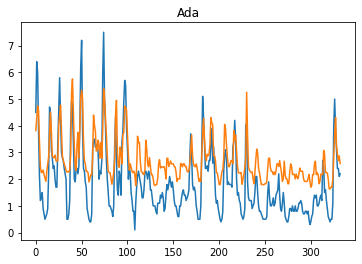

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

model_Ada = AdaBoostRegressor(n_estimators = 100) # model define
model_Ada.fit(X_train, Y_train) # model train

pred = model_Ada.predict(X_test) # predict

# visualize the results
plt.title("Ada")
plt.plot(Y_test.values)
plt.plot(pred)

print("MSE : " + str(mse(Y_test.values, pred)))